In [20]:
###

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sym


kr_w0 = np.array([0.5]) # End-point kr_w and initial value
b = 0.73


visc_n = 1
visc_w = 1
M = visc_w/visc_n # Visc contrast

## Water parameters
L_w = 4
E_w = 3
T_w = 1

## Oil parameters
L_o = 2.5
E_o = 1.5
T_o = 1.3

Sorw = 0.2
Swi = 0.1
kr0_oil = 1

a1 = -0.2



## LET fuctions
def krw_LET(Sw, L, E, T, Swi, Sor, Kr0):
    Swn = (Sw - Swi) / (1 - Swi - Sor)
    return (Kr0*Swn**L) / (Swn**L + E*(1-Swn)**T)

def kro_LET(Sw, L, E, T, Swi, Sor, Kr0):
    Swn = (Sw - Swi) / (1 - Swi - Sor)
    return (Kr0*(1-Swn)**L) / ((1-Swn)**L + E*Swn**T)


## Solve the derivative of LET curves
Sw, L, E, T, Sw_i, Sor, Kr0 = sym.symbols('Sw, L, E, T, Swi, Sor, Kr0')
dkrw_LET = sym.utilities.lambdify((Sw, L, E, T, Sw_i, Sor, Kr0),
                                  sym.diff(krw_LET(Sw, L, E, T, Sw_i, Sor, Kr0), Sw))

dkro_LET = sym.utilities.lambdify((Sw, L, E, T, Sw_i, Sor, Kr0),
                                  sym.diff(kro_LET(Sw, L, E, T, Sw_i, Sor, Kr0), Sw))


## Init value problem solver
dkr_w = lambda sw, kr_w: 1/(1 - b) * (kr_w/sw +
                                      b*M*dkro_LET(sw, L_o, E_o, T_o, Swi, Sorw, kr0_oil) -
                                      (M*dkro_LET(sw, L_o, E_o, T_o, Swi, Sorw, kr0_oil) +
                                      M*kro_LET(sw, L_o, E_o, T_o, Swi, Sorw, kr0_oil)/(1-sw)) + a1)


sw_span = (0.99 - Sorw , 0.01 + Swi)
sw_eval = np.linspace(0.99 - Sorw , 0.01 + Swi, 200)

sol1 = solve_ivp(dkr_w, sw_span, kr_w0, t_eval=sw_eval)

v_p1 = kro_LET(sol1.t, L_o, E_o, T_o, Swi, Sorw, kr0_oil) / visc_n + sol1.y[0] / visc_w

v_p1_diff = np.diff(v_p1) / np.diff(sol1.t)

v_m1 = (sol1.t[:-1] / visc_w * (np.diff(sol1.y[0]/sol1.t) / np.diff(sol1.t)) + 
       (1-sol1.t[:-1]) / visc_n * (np.diff(kro_LET(sol1.t, L_o, E_o, T_o, Swi, Sorw, kr0_oil) / (1-sol1.t)) / np.diff(sol1.t)))




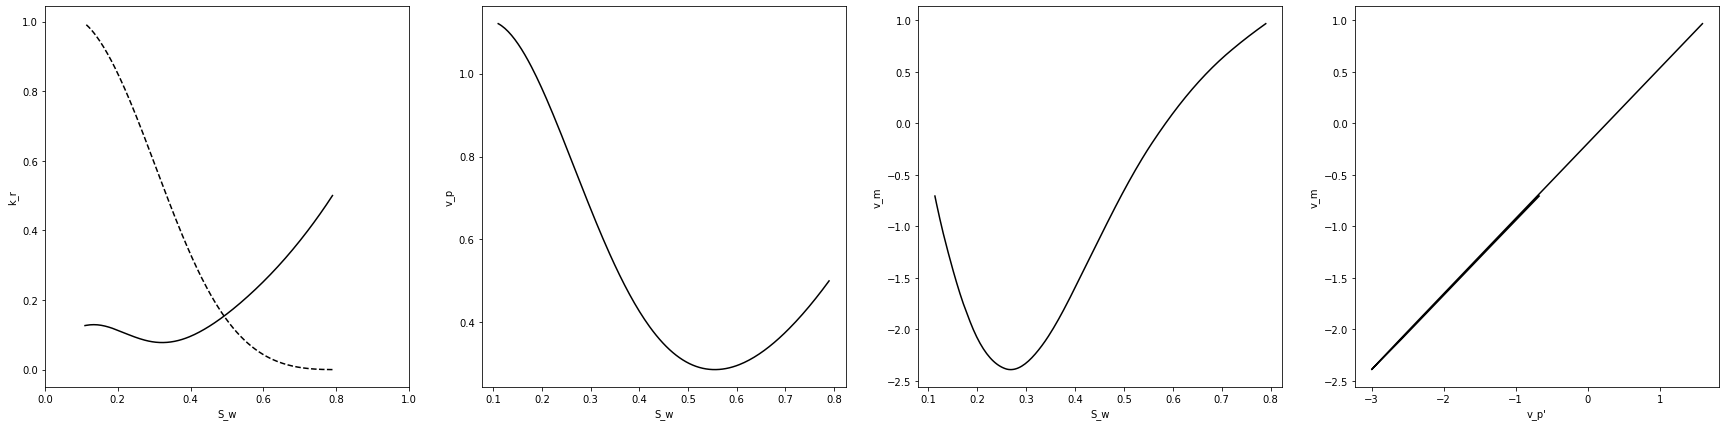

In [21]:
#
plt.figure(figsize=(30,7))

plt.subplot(141)
plt.plot(sol1.t, sol1.y[0], 'k')
plt.plot(sw_eval, kro_LET(sol1.t, L_o, E_o, T_o, Swi, Sorw, kr0_oil), '--k')
plt.xlim(0,1)
plt.ylabel("k_r")
plt.xlabel("S_w")

plt.subplot(142)
plt.plot(sol1.t, v_p1, color='k')
plt.ylabel("v_p")
plt.xlabel("S_w")

plt.subplot(143)
plt.plot(sol1.t[:-1], v_m1, color='k')
plt.ylabel("v_m")
plt.xlabel("S_w")

plt.subplot(144)
plt.plot(v_p1_diff, v_m1, color='k')
plt.ylabel("v_m")
plt.xlabel("v_p'")

plt.show()